In [2]:
from helpers import *
from implementations import *
from preprocessing import *
import numpy as np
import matplotlib.pyplot as plt

### Loading Data and preprocessing

In [3]:
#data_folder = './data/'
data_folder = 'C:/Users/ACER/OneDrive - epfl.ch/Desktop/ML/dataset/'
#data_folder = "C:/Users/plane/OneDrive/Bureau/MilaLyon/MilaLyon/data/"
#data_folder = "C:/Users/ACER/OneDrive - epfl.ch/Desktop/ML/MilaLyon/data/"

In [4]:
csv_data = load_csv_data(data_folder, max_rows=None, dictionnary=True)

# Replace zeros and default values before preprocessing
convert_to_times_per_week(csv_data['x_train'], csv_data['bad_format_no_better'])
convert_to_times_per_week(csv_data['x_test'], csv_data['bad_format_no_better'])
replace_by_zero(csv_data['x_train'], csv_data['x_test'], csv_data['zero_values'])
replace_default_with_nan(csv_data['x_train'], csv_data['x_test'], csv_data['default_values'])

def print_shapes(data):
    for key, value in data.items():
        print(f"{key}: {type(value)} with shape {value.shape if isinstance(value, np.ndarray) else 'N/A'}")
print_shapes(csv_data)


x_train: <class 'numpy.ndarray'> with shape (328135, 321)
x_test: <class 'numpy.ndarray'> with shape (109379, 321)
y_train: <class 'numpy.ndarray'> with shape (328135,)
train_ids: <class 'numpy.ndarray'> with shape (328135,)
test_ids: <class 'numpy.ndarray'> with shape (109379,)
feature_names: <class 'numpy.ndarray'> with shape (321,)
useless: <class 'numpy.ndarray'> with shape (321,)
health_related: <class 'numpy.ndarray'> with shape (321,)
better_elsewhere: <class 'numpy.ndarray'> with shape (321,)
bad_format_no_better: <class 'numpy.ndarray'> with shape (321,)
binary: <class 'numpy.ndarray'> with shape (321,)
one_hot: <class 'numpy.ndarray'> with shape (321,)
zero_values: <class 'numpy.ndarray'> with shape (321,)
default_values: <class 'numpy.ndarray'> with shape (321,)


In [5]:
def preprocess_data(data, nan_drop_threshold=0.2, correlation_threshold=0.02, n_std=3, only_health_related=True, split_val=False, val_size=0.1):

    # Identify and drop features with many missing values
    nan_features = identify_too_many_missing(data["x_train"], data["feature_names"], threshold=nan_drop_threshold)
    drop_features_from_dictionnary(data, nan_features)
    print(len(nan_features), "features with too many missing values dropped.")

    # Replace remaining NaNs with either mean or most frequent value
    replace_nan(data["x_train"], data["x_test"])

    # Keep only health-related features if specified
    if only_health_related:
        non_health_features = data['feature_names'][~data['health_related']].tolist()
        drop_features_from_dictionnary(data, non_health_features)
        print(len(non_health_features), "non health-related features dropped.")

    # One-hot encode categorical features
    n_features_before = data['x_train'].shape[1]
    one_hot_encode(data)
    n_features_after = data['x_train'].shape[1]
    print(f"One-hot encoding completed. Number of features increased from {n_features_before} to {n_features_after}.")

    # Identify and drop features with low correlation to the target
    low_corr_features, _ = identify_low_correlation(data["x_train"], data["y_train"], data["feature_names"], threshold=correlation_threshold)
    drop_features_from_dictionnary(data, low_corr_features)
    print(len(low_corr_features), "features with low correlation dropped.")

    #Clip outliers
    clip_outliers(data['x_train'], data['x_test'], n_std=n_std)

    #Normalize features
    data['x_train'], data['x_test'] = min_max_normalize(data['x_train'], data['x_test'])
    data['y_train'] = (data['y_train'] == 1).astype(int)

    if split_val:
        data['x_train'], data['y_train'], data['x_val'], data['y_val'] = split_train_val(data['x_train'], data['y_train'], val_size=val_size)


In [6]:
data_copy = dict(csv_data)
preprocess_data(data_copy, nan_drop_threshold=0.9, correlation_threshold=0.01, n_std=3, only_health_related=False, split_val=True, val_size=0.1)

99 features with too many missing values dropped.
One-hot encoding completed. Number of features increased from 222 to 512.


c:\Users\ACER\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ACER\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


215 features with low correlation dropped.
Clipped 1857428 values in x_train (1.91% of all entries)
Clipped 619268 values in x_test (1.91%)


In [7]:
print_shapes(data_copy)

x_train: <class 'numpy.ndarray'> with shape (295322, 297)
x_test: <class 'numpy.ndarray'> with shape (109379, 297)
y_train: <class 'numpy.ndarray'> with shape (295322,)
train_ids: <class 'numpy.ndarray'> with shape (328135,)
test_ids: <class 'numpy.ndarray'> with shape (109379,)
feature_names: <class 'numpy.ndarray'> with shape (297,)
useless: <class 'numpy.ndarray'> with shape (297,)
health_related: <class 'numpy.ndarray'> with shape (297,)
better_elsewhere: <class 'numpy.ndarray'> with shape (297,)
bad_format_no_better: <class 'numpy.ndarray'> with shape (297,)
binary: <class 'numpy.ndarray'> with shape (297,)
one_hot: <class 'numpy.ndarray'> with shape (297,)
zero_values: <class 'numpy.ndarray'> with shape (297,)
default_values: <class 'numpy.ndarray'> with shape (709,)
x_val: <class 'numpy.ndarray'> with shape (32813, 297)
y_val: <class 'numpy.ndarray'> with shape (32813,)


Our dataset is unbalanced

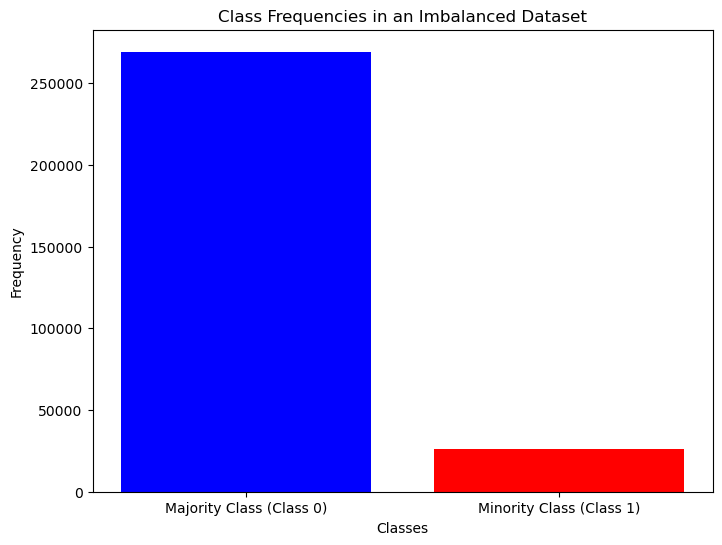

In [8]:

# Count the frequencies of each class
class_counts = [len(data_copy['y_train'][data_copy['y_train'] == 0]), len(data_copy['y_train'][data_copy['y_train'] == 1])]

# Plot the class frequencies using a bar chart
plt.figure(figsize=(8, 6))
plt.bar(['Majority Class (Class 0)', 'Minority Class (Class 1)'], class_counts, color=['blue', 'red'])
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Class Frequencies in an Imbalanced Dataset')
plt.show()

In [12]:
len(data_copy['y_train'][data_copy['y_train'] == 0])/len(data_copy['y_train'][data_copy['y_train'] == 1])

10.324564767236751

## Model Selection and Hyperparameters tuning

### Learning Rate Selection in Logistic Regression

In [9]:
max_iter = 1000
gammas = [0.1, 0.3, 0.5, 0.7, 0.9]

Crossvalidation to find best learning rate

In [36]:
best_gamma, results = cross_validate_gammas(data_copy['x_train'], data_copy['y_train'], gammas, k=5, max_iters=max_iter)

Gamma=0.10000 | Mean F1=0.4151
Gamma=0.30000 | Mean F1=0.4231
Gamma=0.50000 | Mean F1=0.4253
Gamma=0.70000 | Mean F1=0.3988
Gamma=0.90000 | Mean F1=0.3189

✅ Best gamma: 0.50000 (F1=0.4253)


In [10]:
best_gamma = 0.5

Therefore gamma as 0.5. Let's set our baseline with the logistic regression.

✅ Best threshold: 0.19 | F1_val = 0.426 | Acc_val = 0.868


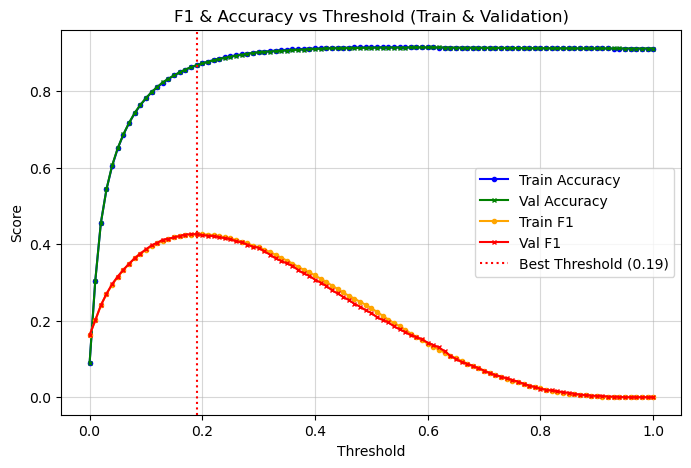

[0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.42607786239302387, 0.4260778623

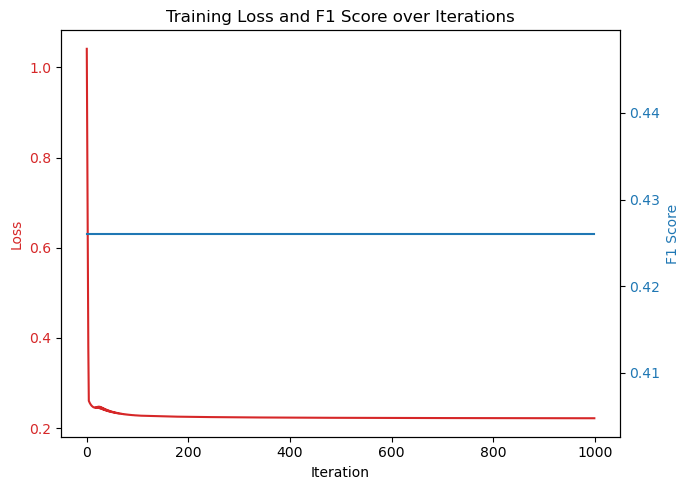

In [59]:
initial_w = np.zeros(data_copy['x_train'].shape[1])
w, best_t, best_f1, best_acc, losses_train, f1_scores, weights = plot_training_validation_performance(
    data_copy['x_train'], data_copy['y_train'],
    data_copy['x_val'], data_copy['y_val'],
    initial_w, max_iters=max_iter, gamma=best_gamma
)


In [61]:
test_pred = predict_labels_logistic(data_copy['x_test'], w, threshold=best_t)
#Convert test_pred to 1 and -1
test_pred = np.where(test_pred == 1, 1, -1)
create_csv_submission(data_copy['test_ids'], test_pred, 'logistic_regression_submission.csv')

### Lambda tuning in ridge logistic regression

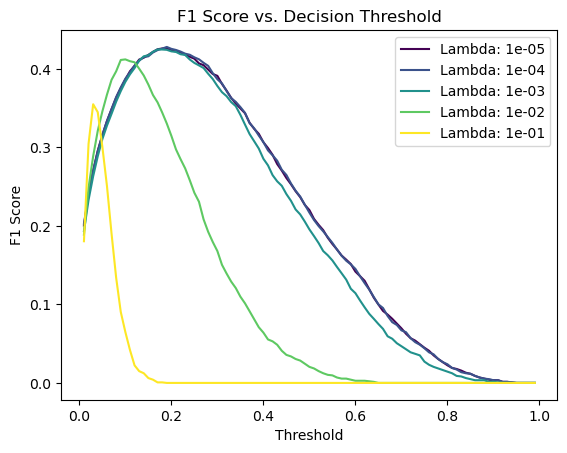

In [ ]:
initial_w = np.zeros(data_copy['x_train'].shape[1])

lambdas = [10**i for i in range(-5, 0)]
thresholds = [i / 100 for i in range(1, 100)]
colors = plt.cm.viridis(np.linspace(0, 1, len(lambdas)))
for i, lam in enumerate(lambdas):
    w, loss,_ = reg_logistic_regression(data_copy['y_train'], data_copy['x_train'], lam, initial_w, max_iter, best_gamma)
    accuracies = []
    f1s = []
    for threshold in thresholds:
        y_pred = predict_labels_logistic(data_copy['x_val'], w, threshold=threshold)
        scores = compute_scores(data_copy['y_val'], y_pred)
        accuracies.append(scores['accuracy'])
        f1s.append(scores['f1_score'])
    plt.plot(thresholds, f1s, label=f"Lambda: {lam:.0e}", color=colors[i])

plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Decision Threshold')
plt.legend()
plt.show()

The best lambda is 1e-05 but we don't get better results than without it.

✅ Best threshold: 0.19 | F1_val = 0.426 | Acc_val = 0.868


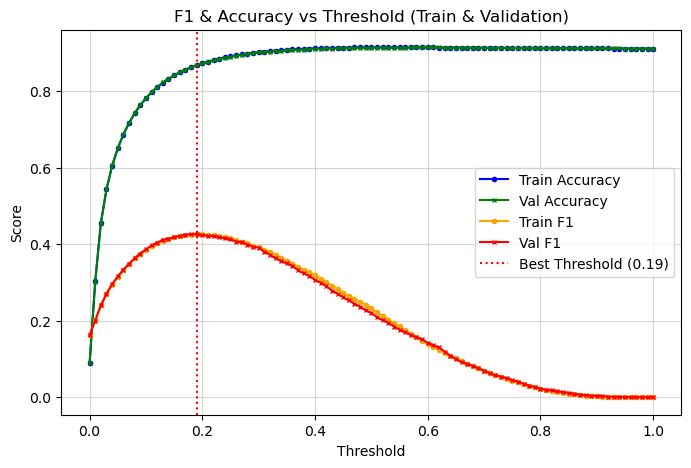

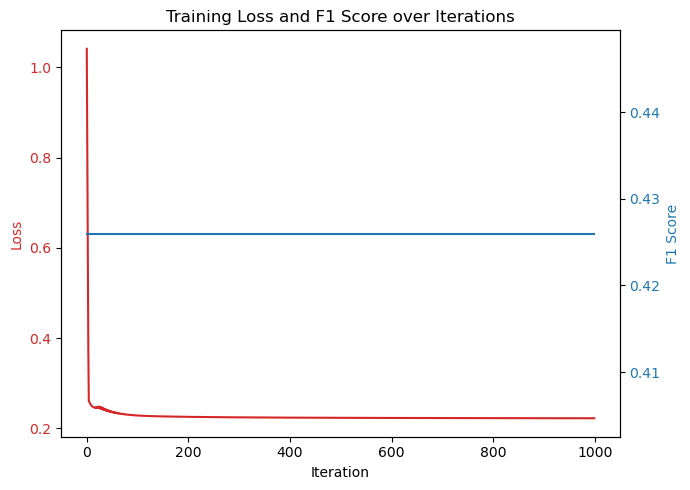

In [62]:
initial_w = np.zeros(data_copy['x_train'].shape[1])
w, best_t, best_f1, best_acc, losses_train, f1_scores, weights = plot_training_validation_performance_reg(
    data_copy['x_train'], data_copy['y_train'],
    data_copy['x_val'], data_copy['y_val'], 10**-5,
    initial_w, max_iters=max_iter, gamma=best_gamma
)


In [63]:
test_pred = predict_labels_logistic(data_copy['x_test'], w, threshold=best_t)
#Convert test_pred to 1 and -1
test_pred = np.where(test_pred == 1, 1, -1)
create_csv_submission(data_copy['test_ids'], test_pred, 'logistic_regression_submission.csv')

### Feature Expansion

In [71]:
degrees = [2,3,4]
best_degree, results = cross_validate_degrees(data_copy['x_train'], data_copy['y_train'], degrees, k=5, max_iters=max_iter, gamma=best_gamma)

Degree=2 | Mean F1=0.4161
Degree=3 | Mean F1=0.3418
Degree=4 | Mean F1=0.1633

✅ Best degree: 2 (F1=0.4161)


In [11]:
best_degree = 2

✅ Best threshold: 0.25 | F1_val = 0.426 | Acc_val = 0.872


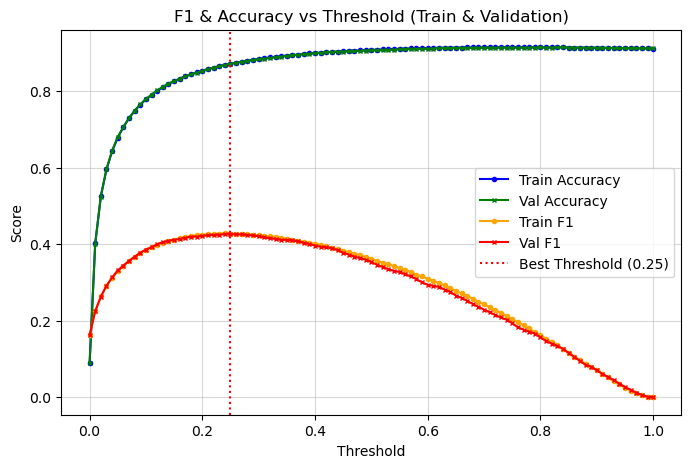

[0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216, 0.4279425779418216,

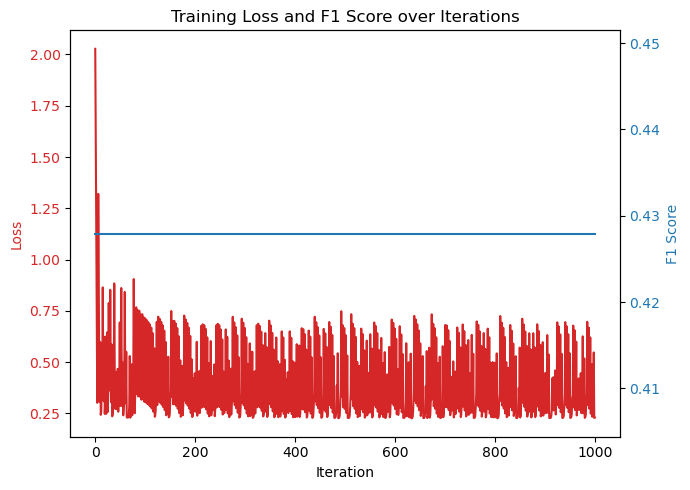

In [72]:
x_train_poly = build_poly(data_copy['x_train'], best_degree)
x_val_poly = build_poly(data_copy['x_val'], best_degree)
x_test_poly = build_poly(data_copy['x_test'], best_degree)

initial_w = np.zeros(x_train_poly.shape[1])
w, best_t, best_f1, best_acc, losses_train, f1_scores, weights = plot_training_validation_performance(
    x_train_poly, data_copy['y_train'],
    x_val_poly, data_copy['y_val'],
    initial_w, max_iters=max_iter, gamma=best_gamma
)

In [73]:
test_pred = predict_labels_logistic(x_test_poly, w, threshold=best_t)
#Convert test_pred to 1 and -1
test_pred = np.where(test_pred == 1, 1, -1)
create_csv_submission(data_copy['test_ids'], test_pred, 'logistic_regression_submission.csv')

### Weighted logistic regression

In [20]:
def cross_validate_weights (x,y, weights, k=5, max_iters=1000, gamma =0.5):
    """Perform k-fold CV to select the best polynomial degree using F1 score."""
    folds = k_fold_indices(y, k)
    results = {}

    for ww in weights:
        
        f1_scores = []
        thresholds = []
        for i in range(k):
            val_idx = folds[i]
            train_idx = np.hstack([folds[j] for j in range(k) if j != i])
            x_tr, y_tr = x[train_idx], y[train_idx]
            x_val, y_val = x[val_idx], y[val_idx]
            sample_weights = 1 +ww*y_tr

            initial_w = np.zeros(x_tr.shape[1])
            w, _= weighted_reg_logistic_regression(y_tr, x_tr,0,sample_weights, initial_w, max_iters, gamma)
           
            best_t, best_f1 = best_threshold(y_val, x_val, w)
            y_pred = predict_labels_logistic(x_val, w, best_t)
            f1_scores.append(best_f1)
            thresholds.append(best_t)

        results[ww] = np.mean(f1_scores)
        print(f"Weights={ww} | Mean F1={np.mean(f1_scores):.4f}")

    best_weight = max(results, key=results.get)
    print(f"\n✅ Best weight: {best_weight} (F1={results[best_weight]:.4f})")
    return best_weight, results

In [22]:
class_weights = [3,5,7,9]
best_weight, results = cross_validate_weights(data_copy['x_train'], data_copy['y_train'], class_weights, k=5, max_iters=max_iter, gamma=best_gamma)

Weights=3 | Mean F1=0.3865
Weights=5 | Mean F1=0.4026
Weights=7 | Mean F1=0.3069
Weights=9 | Mean F1=0.2833

✅ Best weight: 5 (F1=0.4026)


In [23]:
n_pos = np.sum(data_copy['y_train'] == 1)
n_neg = np.sum(data_copy['y_train'] == 0)
N = len(data_copy['y_train'])
w_pos = N / (2 * max(n_pos, 1))
w_neg = N / (2 * max(n_neg, 1))
sample_weights_class_frequency = np.where(data_copy['y_train'] == 1, w_pos, w_neg)

✅ Best threshold: 0.99 | F1_val = 0.395 | Acc_val = 0.802


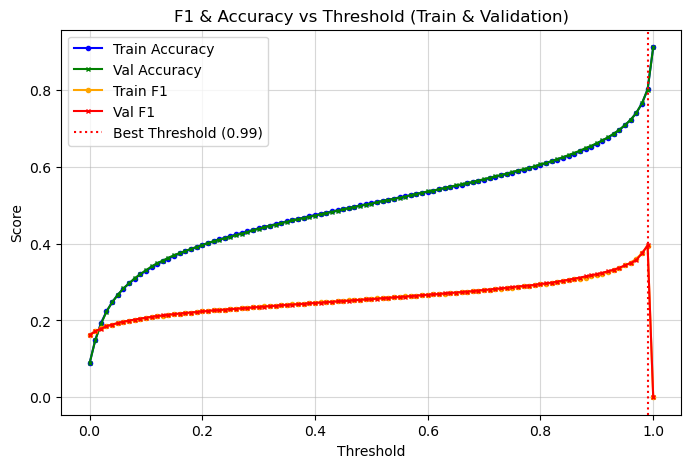

In [ ]:
initial_w = np.zeros(data_copy['x_train'].shape[1])
w, loss = weighted_reg_logistic_regression(data_copy['y_train'], data_copy['x_train'], 0, sample_weights_class_frequency, initial_w, max_iter, best_gamma)
# ---- Threshold sweep ----
thresholds = np.arange(0.0, 1.0 + 0.01, 0.01)
f1_train, acc_train = [], []
f1_val, acc_val = [], []

for t in thresholds:
    y_pred_train = predict_labels_logistic(data_copy['x_train'], w, t)
    y_pred_val = predict_labels_logistic(data_copy['x_val'], w, t)

    scores_train = compute_scores(data_copy['y_train'], y_pred_train)
    scores_val = compute_scores(data_copy['y_val'], y_pred_val)

    f1_train.append(scores_train['f1_score'])
    acc_train.append(scores_train['accuracy'])
    f1_val.append(scores_val['f1_score'])
    acc_val.append(scores_val['accuracy'])

# ---- Best threshold ----
best_idx = np.argmax(f1_val)
best_thr = thresholds[best_idx]
print(f"✅ Best threshold: {best_thr:.2f} | F1_val = {f1_val[best_idx]:.3f} | Acc_val = {acc_val[best_idx]:.3f}")

# ---- Plot F1 & Accuracy vs Threshold ----
plt.figure(figsize=(8,5))
plt.plot(thresholds, acc_train, label='Train Accuracy',  marker='o',  markersize=3, color='blue')
plt.plot(thresholds, acc_val, label='Val Accuracy',  marker='x', markersize=3, color='green')
plt.plot(thresholds, f1_train, label='Train F1', marker='o',markersize = 3, color='orange')
plt.plot(thresholds, f1_val, label='Val F1',  marker='x', markersize=3, color='red')
plt.axvline(best_thr, color='red', linestyle=':', label=f'Best Threshold ({best_thr:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1 & Accuracy vs Threshold (Train & Validation)')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

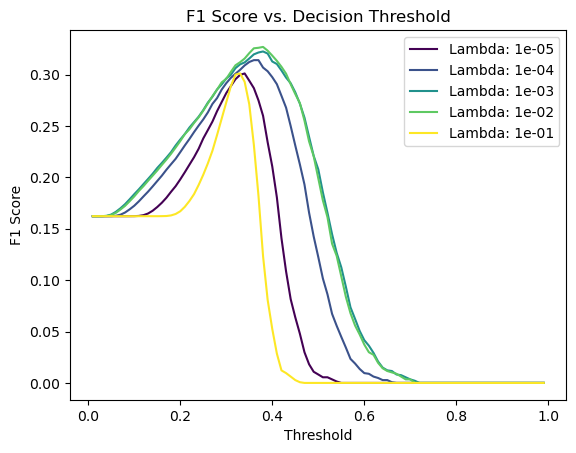

In [9]:
initial_w = np.zeros(data_copy['x_train'].shape[1])
# Define sample weights: weight of 1 for class 0 and weight of 4 for class 1
sample_weights = 1 + 3*data_copy['y_train']

lambdas = [10**i for i in range(-5, 0)]
thresholds = [i / 100 for i in range(1, 100)]
colors = plt.cm.viridis(np.linspace(0, 1, len(lambdas)))
for i, lam in enumerate(lambdas):
    w, loss = weighted_reg_logistic_regression(data_copy['y_train'], data_copy['x_train'], lam, sample_weights, initial_w, 1000, 0.01)
    accuracies = []
    f1s = []
    for threshold in thresholds:
        y_pred = predict_labels_logistic(data_copy['x_val'], w, threshold=threshold)
        scores = compute_scores(data_copy['y_val'], y_pred)
        accuracies.append(scores['accuracy'])
        f1s.append(scores['f1_score'])
    plt.plot(thresholds, f1s, label=f"Lambda: {lam:.0e}", color=colors[i])

plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Decision Threshold')
plt.legend()
plt.show()

In [ ]:
test_pred = predict_labels_logistic(data_copy['x_test'], w, threshold=0.5)
#Convert test_pred to 1 and -1
test_pred = np.where(test_pred == 1, 1, -1)
create_csv_submission(data_copy['test_ids'], test_pred, 'logistic_regression_submission.csv')

### Oversample

In [27]:
import numpy as np

def oversample_data(x, y, ratio=1.0, seed=42):
    """
    Randomly oversample the minority class to reach the desired ratio.

    Args:
        x (np.array): shape (N, D), features
        y (np.array): shape (N,), binary labels (0 or 1)
        ratio (float): desired minority/majority ratio after resampling.
                       e.g., ratio=1.0 => fully balanced (equal classes)
                             ratio=0.5 => minority has half as many as majority
        seed (int): random seed for reproducibility

    Returns:
        x_resampled, y_resampled: oversampled dataset
    """
    np.random.seed(seed)

    # Separate classes
    x_min, x_maj = x[y == 1], x[y == 0]
    n_min, n_maj = len(x_min), len(x_maj)

    # Determine how many minority samples we need
    target_min = int(ratio * n_maj)
    if target_min <= n_min:
        return x, y  # already balanced enough

    # Sample with replacement from minority class
    idx = np.random.choice(n_min, target_min - n_min, replace=True)
    x_extra = x_min[idx]
    y_extra = np.ones(len(idx))

    # Combine
    x_res = np.vstack((x, x_extra))
    y_res = np.hstack((y, y_extra))

    # Shuffle
    perm = np.random.permutation(len(y_res))
    return x_res[perm], y_res[perm]


In [32]:
def cross_validate_oversampling(x, y, ratios, k=5, max_iters=1000, gamma=0.5):
    """
    Perform k-fold CV testing different oversampling ratios.

    Args:
        ratios (list): list of desired minority/majority ratios (e.g. [0.5, 0.75, 1.0])
    """
    folds = k_fold_indices(y, k)
    results = {}

    for r in ratios:
        f1_scores = []
        for i in range(k):
            val_idx = folds[i]
            train_idx = np.hstack([folds[j] for j in range(k) if j != i])

            x_tr, y_tr = x[train_idx], y[train_idx]
            x_val, y_val = x[val_idx], y[val_idx]

            # Oversample only training data
            x_over, y_over = oversample_data(x_tr, y_tr, ratio=r)

            # Train model
            initial_w = np.zeros(x_over.shape[1])
            w, _,_ = logistic_regression(y_over, x_over, initial_w, max_iters=max_iters, gamma=gamma)

            # Find best threshold for validation F1
            best_t, best_f1 = best_threshold(y_val, x_val, w)
            f1_scores.append(best_f1)

        results[r] = np.mean(f1_scores)
        print(f"Oversampling ratio={r:.2f} | Mean F1={np.mean(f1_scores):.4f}")

    best_ratio = max(results, key=results.get)
    print(f"\n✅ Best oversampling ratio: {best_ratio} (F1={results[best_ratio]:.4f})")
    return best_ratio, results


In [35]:
best_ratio, results = cross_validate_oversampling(data_copy['x_train'], data_copy['y_train'], ratios=[0.5, 0.75, 1.0], k=5, max_iters=max_iter, gamma=best_gamma)

Oversampling ratio=0.50 | Mean F1=0.4154
Oversampling ratio=0.75 | Mean F1=0.3464
Oversampling ratio=1.00 | Mean F1=0.3184

✅ Best oversampling ratio: 0.5 (F1=0.4154)


✅ Best threshold: 0.05 | F1_val = 0.424 | Acc_val = 0.867


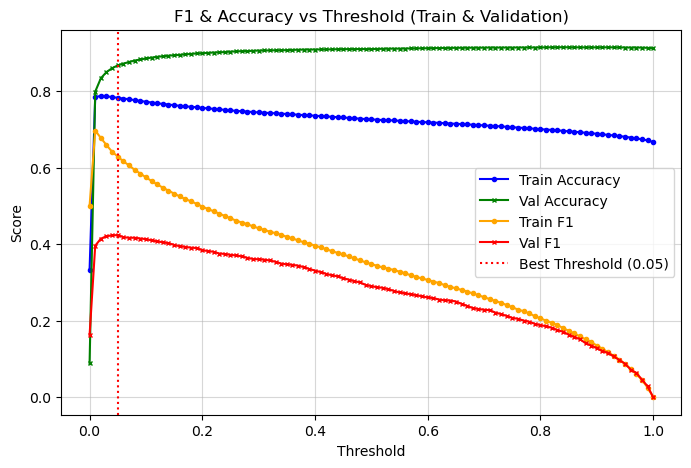

In [36]:
x_over, y_over = oversample_data(data_copy['x_train'], data_copy['y_train'], ratio=best_ratio)
initial_w = np.zeros(x_over.shape[1])
w, loss, _ =logistic_regression(y_over, x_over,initial_w, max_iter, best_gamma)
# ---- Threshold sweep ----
thresholds = np.arange(0.0, 1.0 + 0.01, 0.01)
f1_train, acc_train = [], []
f1_val, acc_val = [], []

for t in thresholds:
    y_pred_train = predict_labels_logistic(x_over, w, t)
    y_pred_val = predict_labels_logistic(data_copy['x_val'], w, t)

    scores_train = compute_scores(y_over, y_pred_train)
    scores_val = compute_scores(data_copy['y_val'], y_pred_val)

    f1_train.append(scores_train['f1_score'])
    acc_train.append(scores_train['accuracy'])
    f1_val.append(scores_val['f1_score'])
    acc_val.append(scores_val['accuracy'])

# ---- Best threshold ----
best_idx = np.argmax(f1_val)
best_thr = thresholds[best_idx]
print(f"✅ Best threshold: {best_thr:.2f} | F1_val = {f1_val[best_idx]:.3f} | Acc_val = {acc_val[best_idx]:.3f}")

# ---- Plot F1 & Accuracy vs Threshold ----
plt.figure(figsize=(8,5))
plt.plot(thresholds, acc_train, label='Train Accuracy',  marker='o',  markersize=3, color='blue')
plt.plot(thresholds, acc_val, label='Val Accuracy',  marker='x', markersize=3, color='green')
plt.plot(thresholds, f1_train, label='Train F1', marker='o',markersize = 3, color='orange')
plt.plot(thresholds, f1_val, label='Val F1',  marker='x', markersize=3, color='red')
plt.axvline(best_thr, color='red', linestyle=':', label=f'Best Threshold ({best_thr:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1 & Accuracy vs Threshold (Train & Validation)')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

In [37]:
test_pred = predict_labels_logistic(data_copy['x_test'], w, threshold=best_thr)
#Convert test_pred to 1 and -1
test_pred = np.where(test_pred == 1, 1, -1)
create_csv_submission(data_copy['test_ids'], test_pred, 'logistic_regression_submission.csv')